<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Columns: 121 entries, ID to original_ngtdm_Strength
dtypes: float64(108), int64(12), object(1)
memory usage: 378.2+ KB
RelapseFreeSurvival (outcome)
38.000000    11
39.000000    10
60.000000    10
31.000000     9
61.000000     9
             ..
0.000000      1
8.000000      1
77.250000     1
53.583333     1
46.916667     1
Name: count, Length: 144, dtype: int64


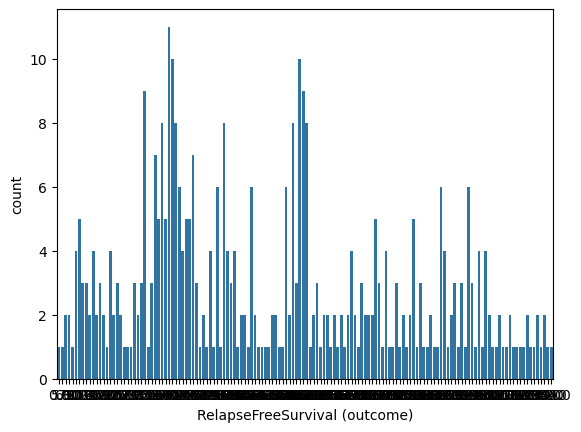

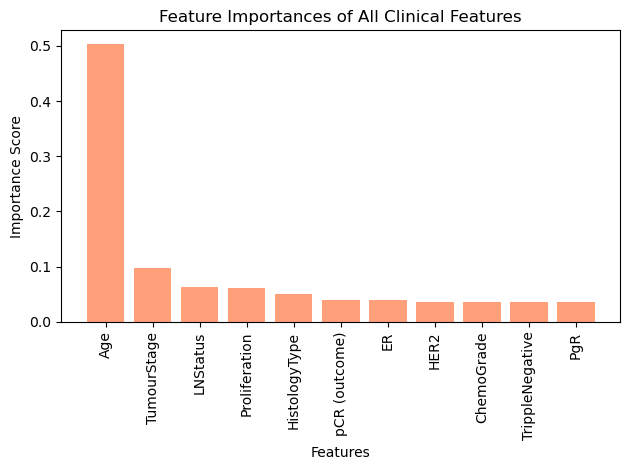

Optimal Number of Features: 7
Selected Features:
Index(['Age', 'ER', 'TrippleNegative', 'Proliferation', 'HistologyType',
       'LNStatus', 'TumourStage'],
      dtype='object')
Number of Components Selected: 2
(400, 7) <class 'pandas.core.frame.DataFrame'>
(400, 2) <class 'numpy.ndarray'>


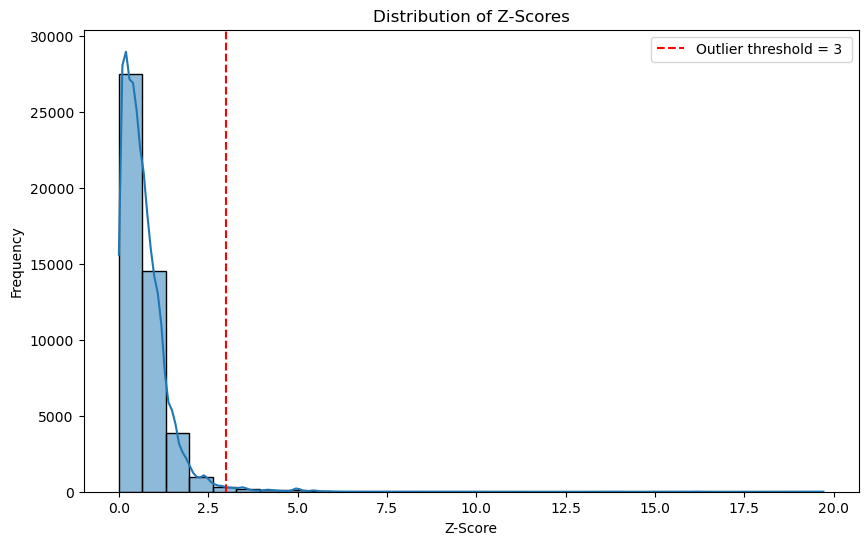

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 读取数据
df = pd.read_csv("TrainDataset2024.csv")
df.head()
df.describe()
df.info()

# 删除 "ID" 列
df.drop("ID", axis=1, inplace=True)
df.head()

from sklearn.impute import SimpleImputer

# 用中位数填充缺失值
imputer = SimpleImputer(strategy='median')
df.replace(999, np.nan, inplace=True)
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
df.describe()

import seaborn as sns

# 打印回归目标变量的分布
print(df['RelapseFreeSurvival (outcome)'].value_counts())
sns.countplot(x="RelapseFreeSurvival (outcome)", data=df)

# 将目标变量赋值为回归任务的 y_reg
y_reg = df["RelapseFreeSurvival (outcome)"]

# 删除回归目标变量列
df.drop("RelapseFreeSurvival (outcome)", axis=1, inplace=True)

# 重新分配自变量
X_clinical = df.iloc[:, :11]
X_mri = df.iloc[:, 11:]

from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor

# 使用随机森林回归器进行特征选择
model_all = RandomForestRegressor(random_state=42)
model_all.fit(X_clinical, y_reg)

all_importances = model_all.feature_importances_
indices = np.argsort(all_importances)[::-1]

plt.figure()
plt.title("Feature Importances of All Clinical Features")
plt.bar(X_clinical.columns[indices], all_importances[indices], color="lightsalmon", align="center")
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

# 使用 RFECV 进行递归特征消除
model = RandomForestRegressor(random_state=42)

rfecv = RFECV(estimator=model, step=1, cv=5, scoring='neg_mean_squared_error')
rfecv.fit(X_clinical, y_reg)

selected_features = X_clinical.columns[rfecv.support_]
print("Optimal Number of Features:", rfecv.n_features_)
print("Selected Features:")
print(selected_features)
X_clinical_fs = X_clinical[selected_features]

# 使用 PCA 降维
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_mri_dr = pca.fit_transform(X_mri)

print("Number of Components Selected:", pca.n_components_)
print(X_clinical_fs.shape, type(X_clinical_fs))
print(X_mri_dr.shape, type(X_mri_dr))

# 合并临床特征和MRI特征
X = np.hstack((X_clinical_fs.values, X_mri_dr))
X.shape, type(X.shape)

# 计算 Z 分数，检测异常值
from scipy.stats import zscore

z_scores = np.abs(zscore(df))
z_scores = z_scores.to_numpy()
z_scores_flat = z_scores.flatten()

plt.figure(figsize=(10, 6))
sns.histplot(z_scores_flat, bins=30, kde=True)
plt.title("Distribution of Z-Scores")
plt.xlabel("Z-Score")
plt.ylabel("Frequency")
plt.axvline(x=3, color='r', linestyle='--', label="Outlier threshold = 3 ")
plt.legend()
plt.show()

SVR Mean Squared Error: 801.9930500386193
SVR R^2 Score: -0.004931238105535973
Decision Tree Mean Squared Error: 1673.239496531014
Decision Tree R^2 Score: -1.0966399132947906


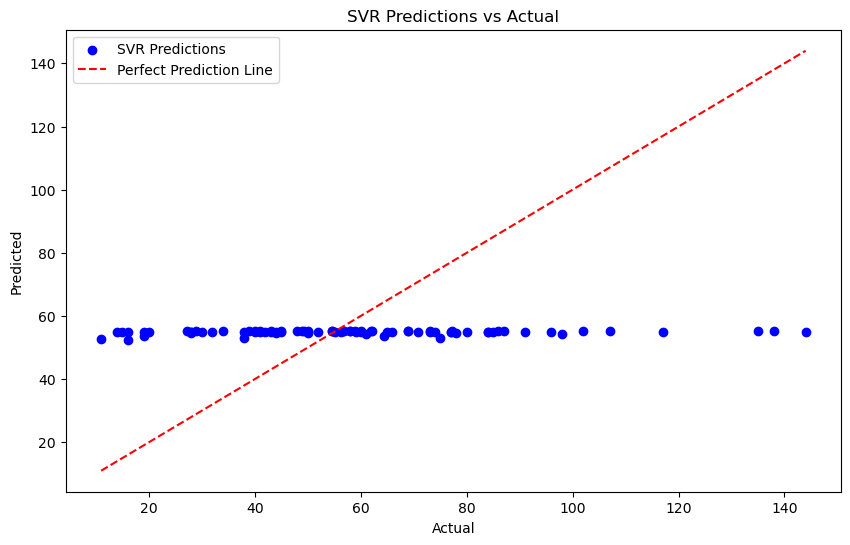

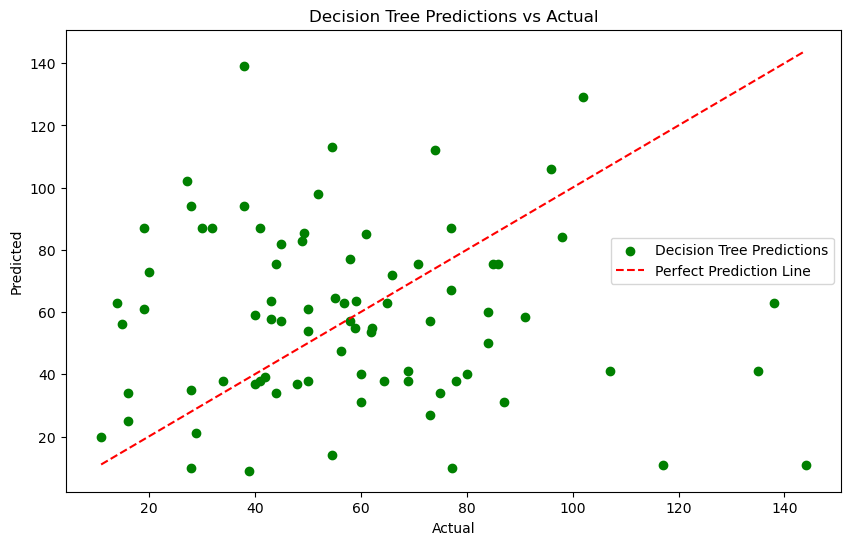

In [2]:
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# 将数据集拆分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y_reg, test_size=0.20, random_state=42)

# 1. 支持向量回归 (SVR)
svr = SVR(kernel='rbf', C=100, epsilon=0.1)
svr.fit(X_train, y_train)

# 预测
y_pred_svr = svr.predict(X_test)

# 评估性能
mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)
print("SVR Mean Squared Error:", mse_svr)
print("SVR R^2 Score:", r2_svr)

# 2. 决策树回归 (Decision Tree Regressor)
dt_regressor = DecisionTreeRegressor(random_state=42)
dt_regressor.fit(X_train, y_train)

# 预测
y_pred_dt = dt_regressor.predict(X_test)

# 评估性能
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)
print("Decision Tree Mean Squared Error:", mse_dt)
print("Decision Tree R^2 Score:", r2_dt)

# 可视化结果（SVR）
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_svr, color='blue', label='SVR Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Perfect Prediction Line")
plt.title("SVR Predictions vs Actual")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()
plt.show()

# 可视化结果（Decision Tree）
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_dt, color='green', label='Decision Tree Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Perfect Prediction Line")
plt.title("Decision Tree Predictions vs Actual")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()
plt.show()


Linear Regression Mean Squared Error: 838.7685406070492
Linear Regression R^2 Score: -0.051012484404479475


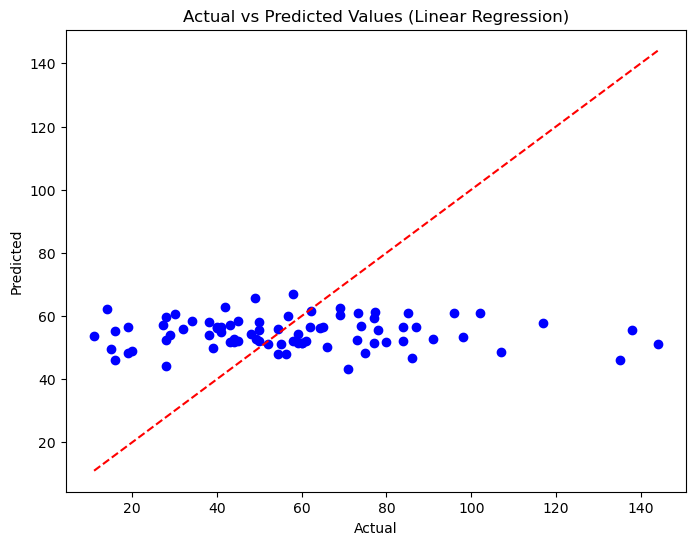

In [3]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()

# 训练线性回归模型
lr_model.fit(X_train, y_train)

# 对测试集进行预测
y_pred = lr_model.predict(X_test)

# 评估模型性能
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression Mean Squared Error: {mse}")
print(f"Linear Regression R^2 Score: {r2}")

# 可视化回归结果
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # 线性拟合线
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Values (Linear Regression)")
plt.show()

MLPRegressor Mean Squared Error: 361759734623.9174
MLPRegressor R^2 Score: -453300258.8898298


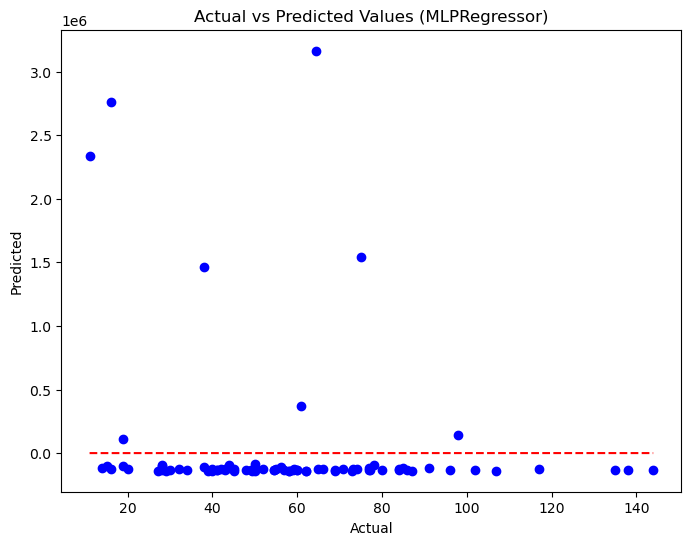

In [4]:
# 构建MLP回归模型
from sklearn.neural_network import MLPRegressor


model_mlp = MLPRegressor(hidden_layer_sizes=(128, 64, 32), activation='relu', solver='adam', max_iter=500, random_state=42)

# 训练模型
model_mlp.fit(X_train, y_train)

# 预测
y_pred = model_mlp.predict(X_test)

# 评估模型性能
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MLPRegressor Mean Squared Error: {mse}")
print(f"MLPRegressor R^2 Score: {r2}")

# 可视化回归结果
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # 线性拟合线
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Values (MLPRegressor)")
plt.show()